In [3]:
import fig01to03 as nb
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting
from scipy.optimize import least_squares

from fmri_timescales import acf_utils, plts, timescale_utils


# set notebook defaults
plt.rcParams.update({"font.size": 20, "font.sans-serif": ["Open Sans"]})
np.set_printoptions(precision=3)

**fixed parameters for AR1, AR2, and HCP simulations**

In [4]:
def get_nls_params(coeffs, coeff_type, n_timepoints):
    """return theoretical nls phi parameters"""

    if coeff_type == "ar_coeffs":
        coeffs = acf_utils.ar_to_acf(coeffs, n_lags=n_timepoints)
    elif coeff_type != "acf":
        raise ValueError("coeff_type in 'ar_coeffs' or 'acf'")

    ks = np.arange(len(coeffs))
    func = lambda phi, k, coeffs: (coeffs - phi**k)
    nls_fit = least_squares(fun=func, args=(ks, coeffs), x0=0, bounds=(-1, +1), ftol=1e-6)
    return nls_fit.x[0]


# set fixed parameters #
n_timepoints, n_repeats = 4800, 10000

# AR1 #
ar1_sim_phis = np.linspace(0.1, 0.8, 5)
ar1_lls_phis = ar1_sim_phis
ar1_lls_taus = -1 / np.log(ar1_lls_phis)
ar1_nls_phis = ar1_lls_phis
ar1_nls_taus = ar1_lls_taus

# AR2 #
ar2_sim_phis = np.array(
    [[0.091, 0.09], [0.229, 0.182], [0.347, 0.229], [0.471, 0.24], [0.646, 0.193]]
)
ar2_lls_phis = ar1_lls_phis
ar2_lls_taus = ar1_lls_taus
ar2_nls_phis = np.array(
    [get_nls_params(ar_coeff, "ar_coeffs", n_timepoints) for ar_coeff in ar2_sim_phis]
)
ar2_nls_taus = -1 / np.log(ar2_nls_phis)

# HCP #
acf = acf_utils.ACF()
X_hcp = (
    np.load("./data/nsubjects-10_nregions-300_hcp.npy")
    .astype(np.float32)[1, :, [142, 125, 136, 6, 11]]  # phi in {0.1, 0.28, 0.45, 0.62, 0.8}
    .T
)
acfs_ = acf.fit_transform(X_hcp, X_hcp.shape[0])
zero_idx = np.argmax(acfs_ <= 0, axis=0)
mask = np.arange(len(acfs_)).reshape(-1, 1) >= zero_idx
acfs_[mask] = 0  # set \rho_k to zero after k where \rho_k=0
acm_ = acf_utils.acf_to_toeplitz(acfs_, len(acfs_))

hcp_lls_phis = ar1_lls_phis
hcp_lls_taus = ar1_lls_taus
hcp_nls_phis = np.array([get_nls_params(acf_, "acf", n_timepoints) for acf_ in acfs_.T])
hcp_nls_taus = -1 / np.log(hcp_nls_phis)

**fig01-03, panel a**

In [ ]:
n_lags = 50
colors = ["#313695", "#72ABD0", "#FEDE8E", "#F57245", "#A70226"]

# fig01-a
fig, ax = plt.subplots(figsize=(12, 5), layout="constrained")
for idx in range(5):
    ar1_acf = acf_utils.ar_to_acf(ar1_sim_phis[idx], n_lags=n_lags)
    ax.plot(ar1_acf, c=colors[idx], lw=4, ls="-", alpha=0.5)
    ax.plot(ar1_acf, c=colors[idx], lw=2, ls="--")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\rho_k$")
ax.axhline(y=1 / np.e, color="k", linestyle="--", linewidth=1)
ax.annotate(r"$1/e \approx 0.37$", xy=(40, 1 / np.e), xytext=(40, 1 / np.e + 0.02))
fig.savefig("../figures/fig01-acf.png", dpi=300)


# fig02-a
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), layout="constrained")
plts.plot_stationarity_triangle(axs[0], fill_alpha=0.1, annotate=False)
for idx in range(5):
    phi1 = np.linspace(0, 2, 100)
    phi2 = 1 - phi1 / ar1_lls_phis[idx]
    axs[0].plot(phi1, phi2, c=colors[idx], ls="--", lw=1)
    axs[0].scatter(ar2_sim_phis[idx, 0], ar2_sim_phis[idx, 1], c=colors[idx], s=60)

    ar1_acf = acf_utils.ar_to_acf(ar1_sim_phis[idx], n_lags=n_lags)
    ar2_acf = acf_utils.ar_to_acf(ar2_sim_phis[idx, :], n_lags=n_lags)
    axs[1].plot(ar2_acf, c=colors[idx], lw=4, alpha=0.5)
    axs[1].plot(ar1_acf, c=colors[idx], lw=2, ls="--")
axs[1].set_xlabel(r"$k$")
axs[1].set_ylabel(r"$\rho_k$")
axs[1].axhline(y=1 / np.e, color="k", linestyle="--", linewidth=1)
axs[1].annotate(r"$1/e \approx 0.37$", xy=(30, 1 / np.e), xytext=(30, 1 / np.e + 0.02))
fig.savefig("../figures/fig02-acf.png", dpi=300)


# fig03-a
fig, ax = plt.subplots(figsize=(12, 5), layout="constrained")

for idx in range(5):
    ar1_acf = acf_utils.ar_to_acf(ar1_sim_phis[idx], n_lags=n_lags)
    ax.plot(acfs_[:n_lags, idx], c=colors[idx], lw=4, ls="-", alpha=0.5)
    ax.plot(ar1_acf, c=colors[idx], lw=2, ls="--")

ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\rho_k$")
ax.axhline(y=1 / np.e, color="k", linestyle="--", linewidth=1)
ax.annotate(r"$1/e \approx 0.37$", xy=(40, 1 / np.e), xytext=(40, 1 / np.e + 0.02))
fig.savefig("../figures/fig03-acf.png", dpi=300)

# fig03-a brain regions
hcp_coordinates = np.load("./data/nregions-300_coordinates.npy")[[142, 125, 136, 6, 11], :]
hcp_coordinates.shape

fig, ax = plt.subplots(figsize=(6, 2))
plotting.plot_markers(
    np.arange(5),
    node_coords=hcp_coordinates,
    node_cmap="RdYlBu_r",
    display_mode="lr",
    alpha=1,
    node_size=50,
    annotate=False,
    axes=ax,
    colorbar=False,
)
fig.savefig("../figures/fig03-regions.png", dpi=300)

**parameter recovery simulations**

In [6]:
# !! 1 min runtime !!

# initialize estimators
n_repeats = 1000  # set to 10,000 to reproduce paper (10 min runtime)
n_timepoints, n_jobs, rs = 4800, -2, 6
var_n_lags = int(0.75 * n_timepoints ** (1 / 3))  # (Stock and Watson, 2015)
models = {
    "lls_nr": timescale_utils.LLS(var_estimator="non-robust", var_n_lags=var_n_lags, n_jobs=n_jobs),
    "lls_nw": timescale_utils.LLS(var_estimator="newey-west", var_n_lags=var_n_lags, n_jobs=n_jobs),
    "nls_nr": timescale_utils.NLS(
        var_estimator="non-robust", var_n_lags=None, acf_n_lags=20, n_jobs=n_jobs
    ),
    "nls_nw": timescale_utils.NLS(
        var_estimator="newey-west", var_n_lags=None, acf_n_lags=20, n_jobs=n_jobs
    ),
}

ar1_results = nb.run_simulation(ar1_sim_phis, n_timepoints, models, random_seed=rs)
ar2_results = nb.run_simulation(ar2_sim_phis, n_timepoints, models, random_seed=rs)
hcp_results = nb.run_simulation(ar1_sim_phis, n_timepoints, models, acm=acm_, random_seed=rs)

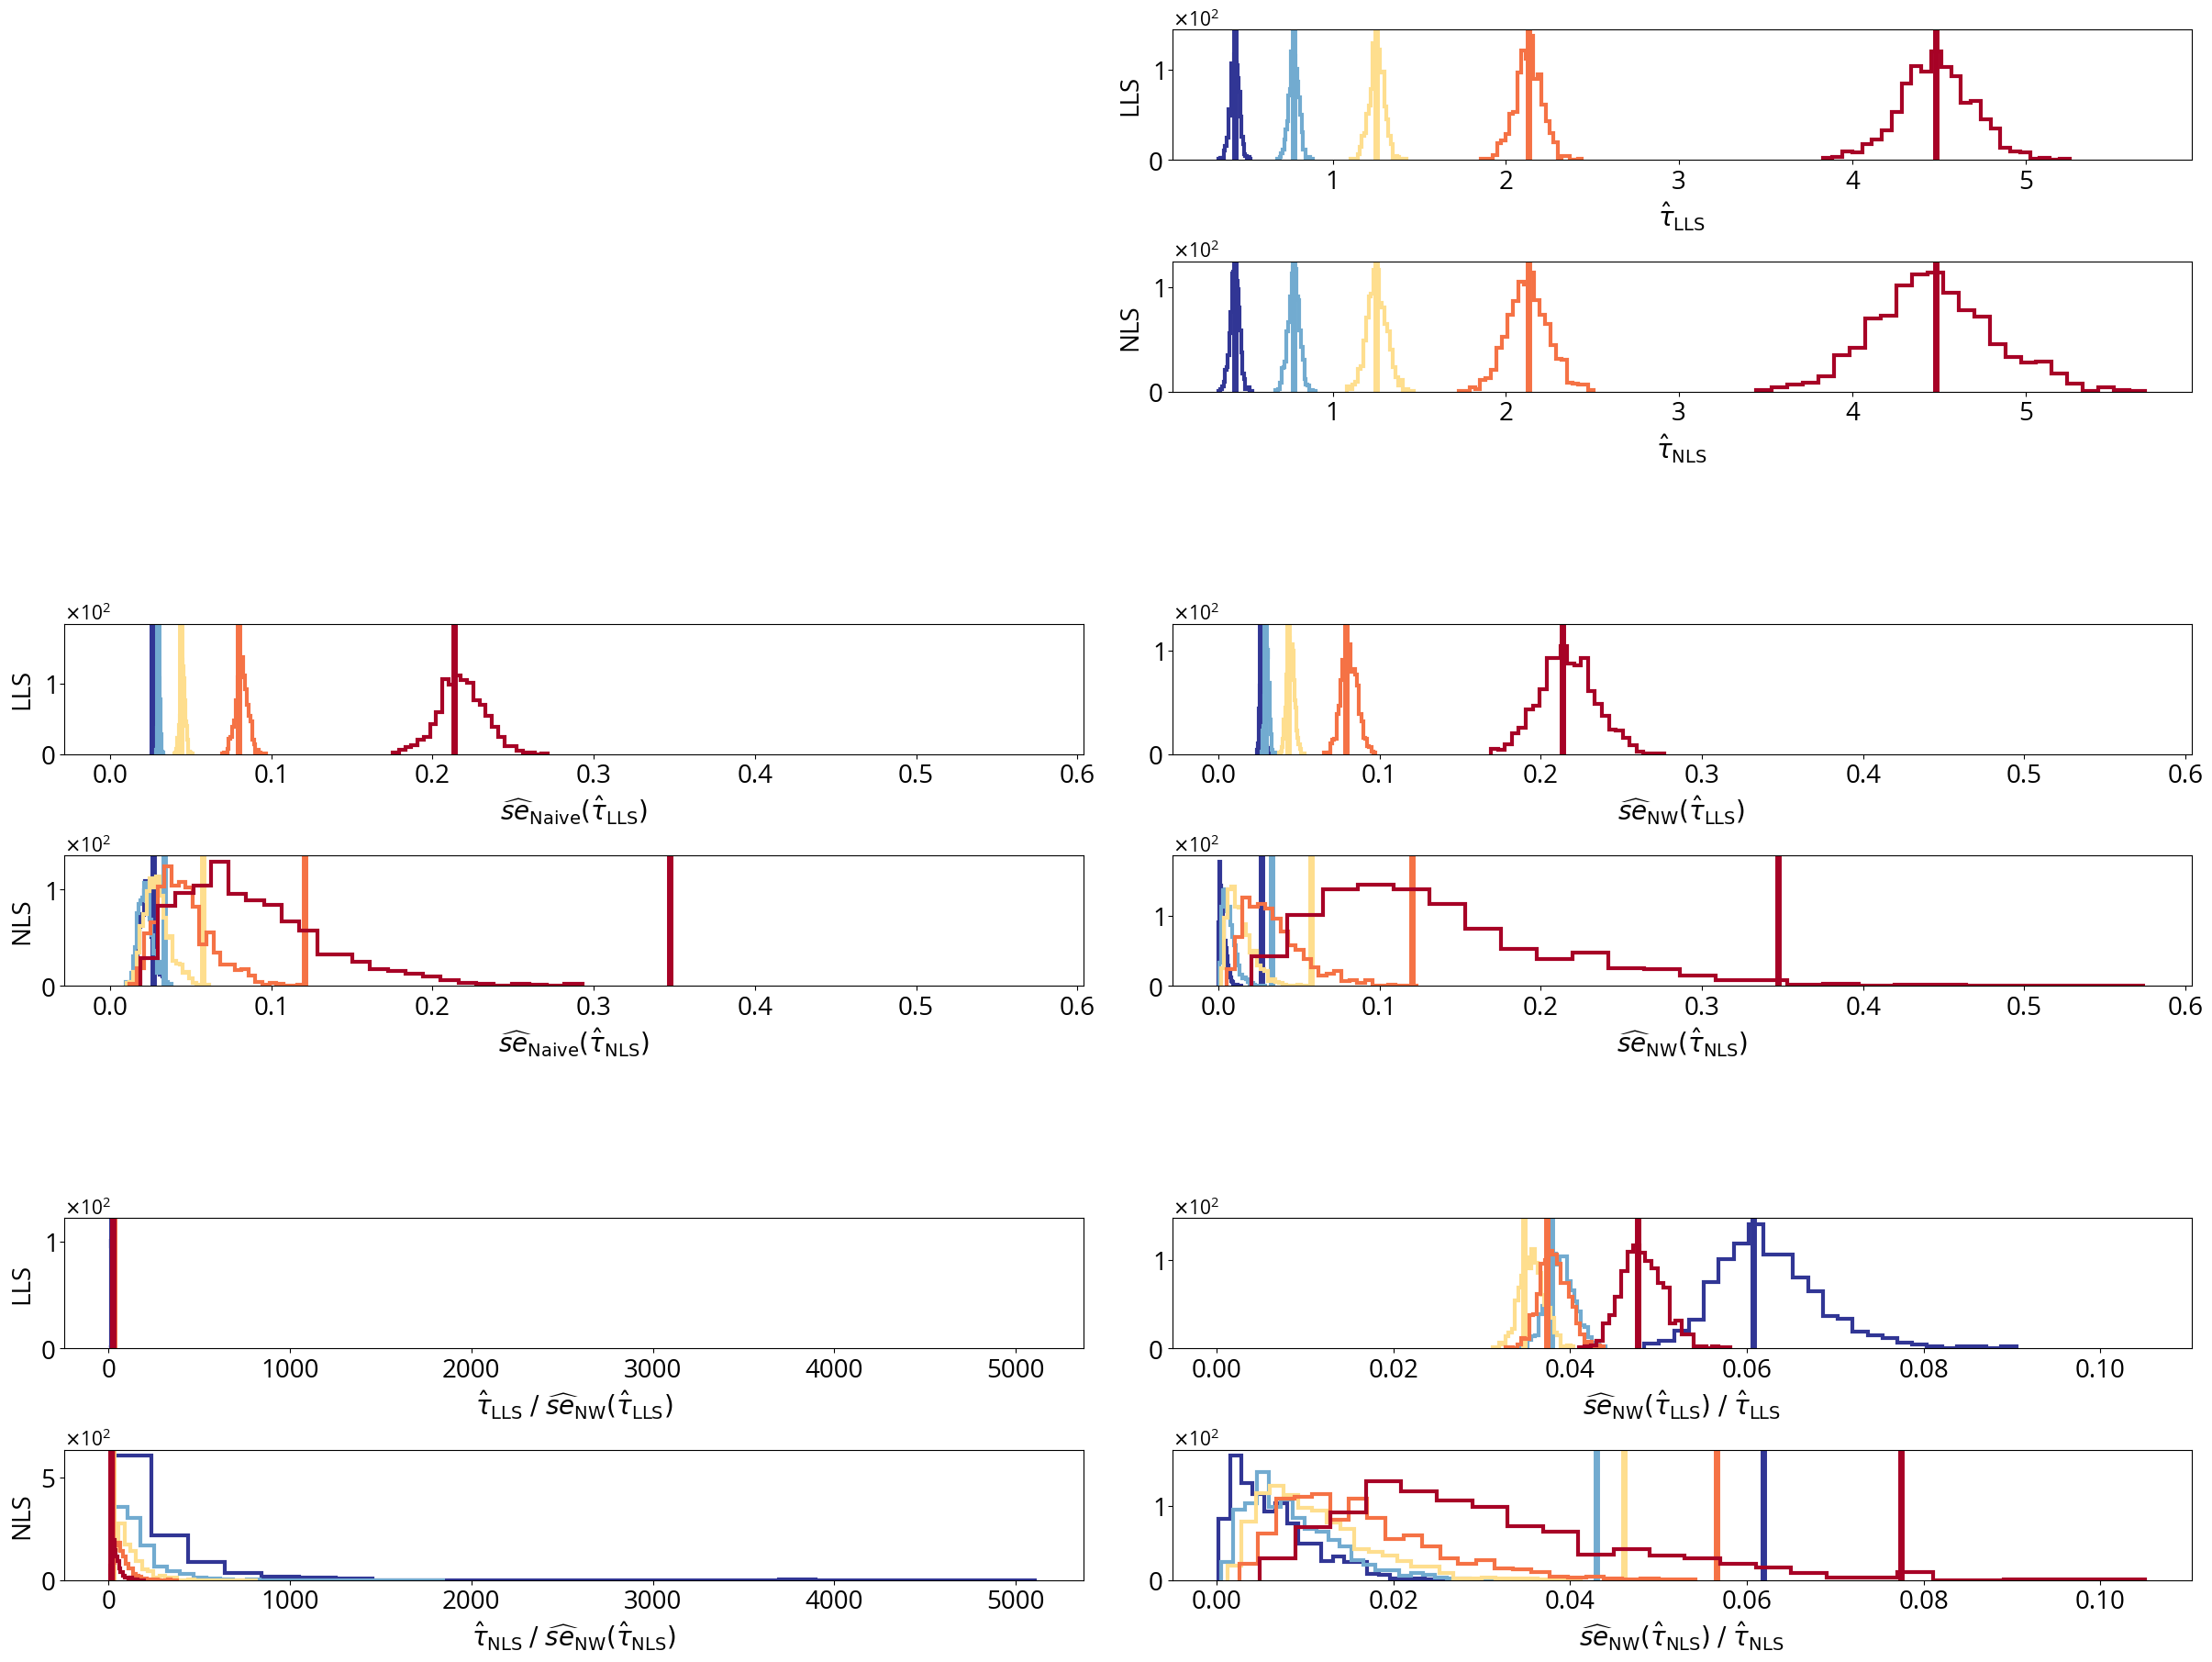

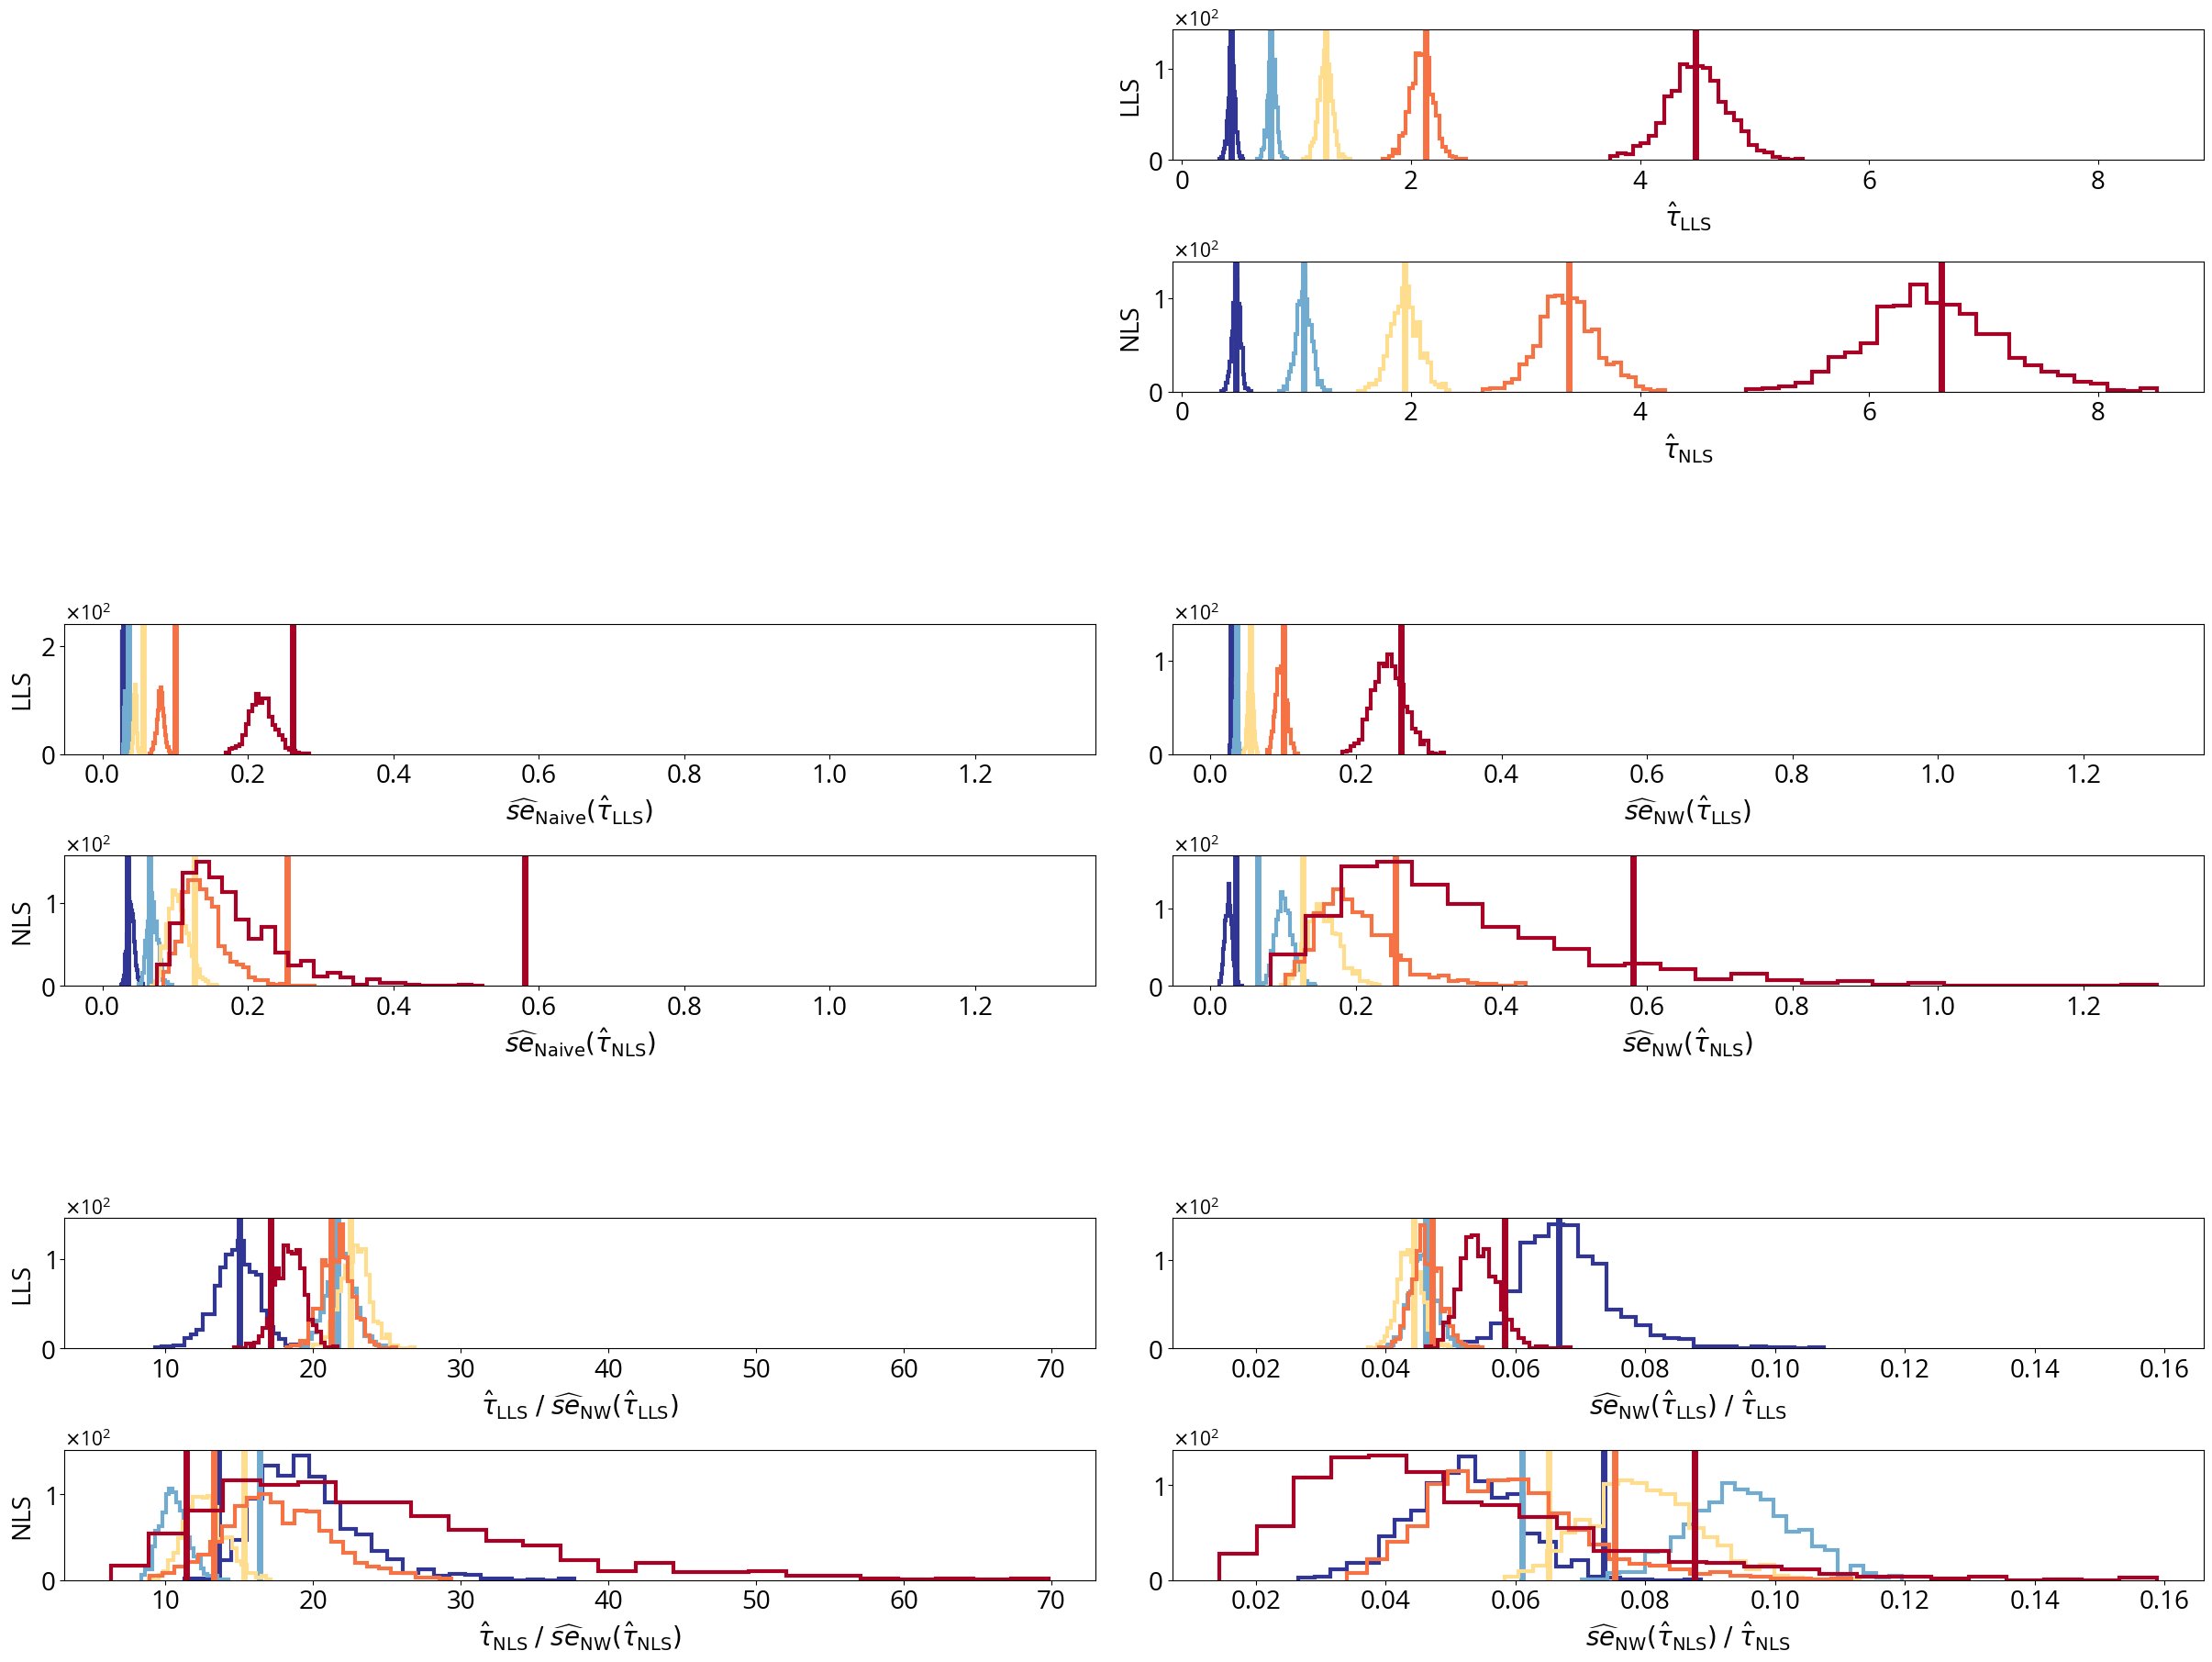

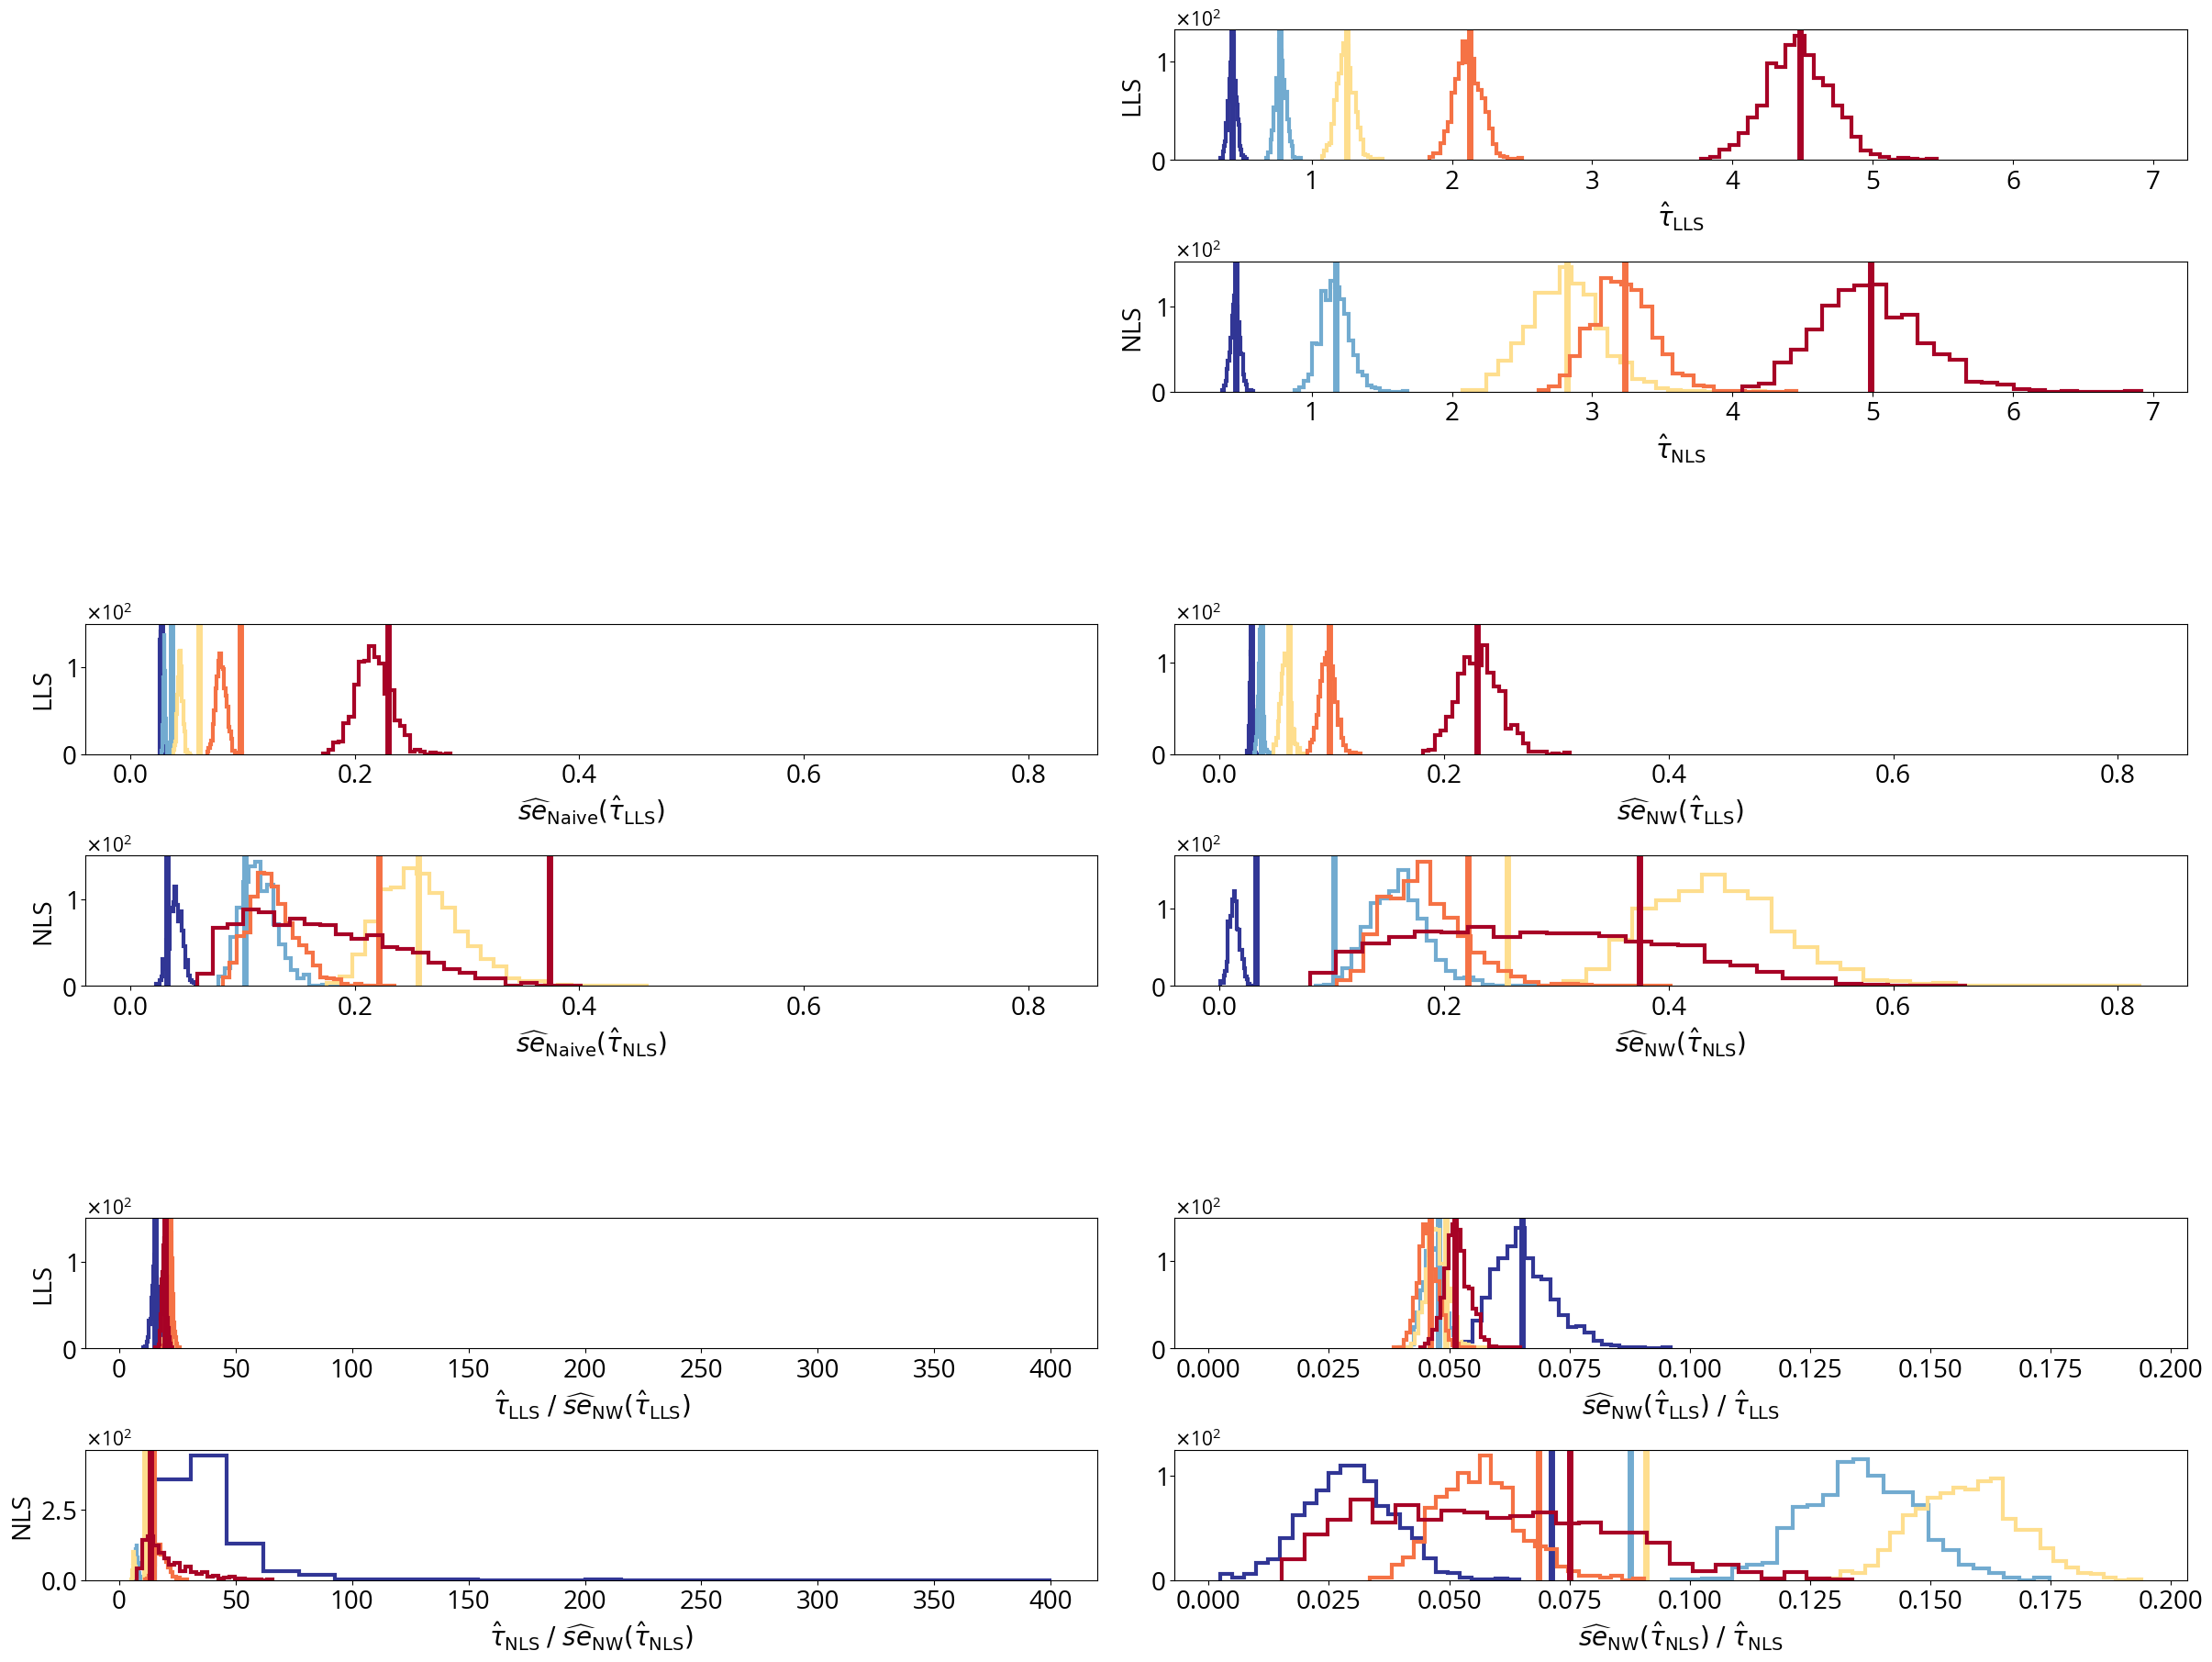

In [7]:
fig01 = nb.plot_simulation(ar1_results, ar1_lls_taus, ar1_nls_taus)
fig02 = nb.plot_simulation(ar2_results, ar2_lls_taus, ar2_nls_taus)
fig03 = nb.plot_simulation(hcp_results, hcp_lls_taus, hcp_nls_taus)